# MMM-Py grib2 format mosaic reading demonstration

The NOAA MRMS mosaics recently changed format (AGAIN!), so MMM-Py has been updated to account for this. As of v1.4, MMM-Py can read MRMS grib2 files and populate its MosaicTile as before. The way the grib files are arranged is every altitude slice is its own separate file. This has pluses (smaller size per file, no more regional tiles, can throw out unnecessary altitudes) and minuses (33 files per time step!). The nice thing about keeping it in the MosaicTile framework is we still have access to its subsection() and write_mrms_binary() methods. So if needed we can cut down the size of our domain and write out a single file that describes it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import mmmpy
%matplotlib inline

/Users/tjlang/anaconda/lib/python2.7/site-packages/mpl_toolkits/__init__.py:2: UserWarning: Module argparse was already imported from /Users/tjlang/anaconda/lib/python2.7/argparse.pyc, but /Users/tjlang/anaconda/lib/python2.7/site-packages is being added to sys.path
  __import__('pkg_resources').declare_namespace(__name__)


In [2]:
BASE_PATH = '/Users/tjlang/Documents/Python/DataForTesting'
TMPDIR = BASE_PATH + '/tmpdir/'
WGRIB2_PATH = BASE_PATH + '/MRMSupdates2015/MRMS_modified_wgrib2_v2.0.1/wgrib2/'
GRIB_PATH = BASE_PATH + '/MRMSupdates2015/MRMS_GRIB2_SAMPLE-reflectivity_3d_plus/'
gf = glob.glob(GRIB_PATH+'*.grib2.gz')

After defining where we can find everything, we can now pass a list of grib2 files to MMM-Py's MosaicTile class so that it can read them and populate the necessary attributes. What happens is that MMM-Py uses the os module to call MRMS-modfied wgrib2 to convert grib2 files to netCDFs that are easier to read. Thus, you need to install the MRMS-modifed wgrib2 package, from here: ftp://ftp.nssl.noaa.gov/projects/MRMS/GRIB2_DECODERS/MRMS_modified_wgrib2_v2.0.1-selectfiles.tgz

At some point I hope to get the GRIB_API library updated with the MRMS changes so that we can use pygrib module.

In [3]:
tile = mmmpy.MosaicTile(filename=gf, verbose=True, wgrib2_path=WGRIB2_PATH, nc_path=TMPDIR,
                        wgrib2_name='wgrib2')


********************
read_mosaic_grib():
>>>>  /Users/tjlang/Documents/Python/DataForTesting/MRMSupdates2015/MRMS_modified_wgrib2_v2.0.1/wgrib2/wgrib2 /Users/tjlang/Documents/Python/DataForTesting/MRMSupdates2015/MRMS_GRIB2_SAMPLE-reflectivity_3d_plus/MRMS_MergedReflectivityQC_00.75_20141208-120035.grib2 -netcdf /Users/tjlang/Documents/Python/DataForTesting/tmpdir/MRMS_MergedReflectivityQC_00.75_20141208-120035.grib2.nc
>>>>  /Users/tjlang/Documents/Python/DataForTesting/MRMSupdates2015/MRMS_modified_wgrib2_v2.0.1/wgrib2/wgrib2 /Users/tjlang/Documents/Python/DataForTesting/MRMSupdates2015/MRMS_GRIB2_SAMPLE-reflectivity_3d_plus/MRMS_MergedReflectivityQC_01.00_20141208-120035.grib2 -netcdf /Users/tjlang/Documents/Python/DataForTesting/tmpdir/MRMS_MergedReflectivityQC_01.00_20141208-120035.grib2.nc
>>>>  /Users/tjlang/Documents/Python/DataForTesting/MRMSupdates2015/MRMS_modified_wgrib2_v2.0.1/wgrib2/wgrib2 /Users/tjlang/Documents/Python/DataForTesting/MRMSupdates2015/MRMS_GRIB2_SAMPLE-re

Oof, that took a while. But look at it this way. We just read in a full 3D mosaic that covers the CONUS. In terms of overall time, to do the same from gzipped MRMS binaries and then call mmmpy.stich_mosaic_tiles() is not far off. Plus, we'll see later how to subsection the data before reading it in, which speeds things up.

The keywords above tell MosaicTile how to find wgrib2 and where to put the intermediary netCDFs. There are default values in mmmpy.py that you can change to match your setup, so you don't need to do this all the time.

<hr>

Now, the MosaicDisplay class has been recently added to MMM-Py. This consolidates all the plotting methods into a different class, thereby simplifying MosaicTile. However, this adds an additional step. On the plus side, it is now easier to create custom multi-panel plots.

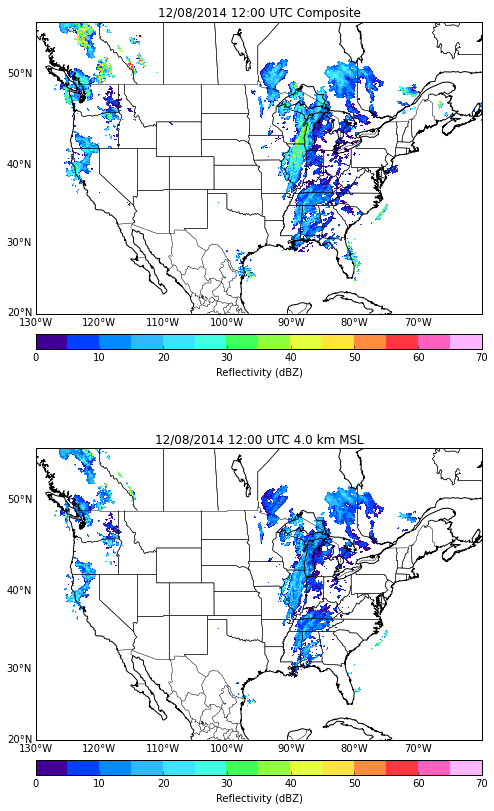

In [4]:
display = mmmpy.MosaicDisplay(tile)
fig = plt.figure(figsize=(8,14))
ax1 = fig.add_subplot(211)
display.plot_horiz()
ax2 = fig.add_subplot(212)
display.plot_horiz(level=4)

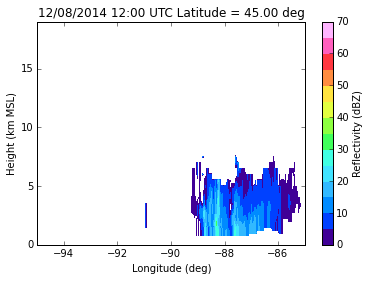

In [5]:
display.plot_vert(lat=45, xrange=[-95,-85])

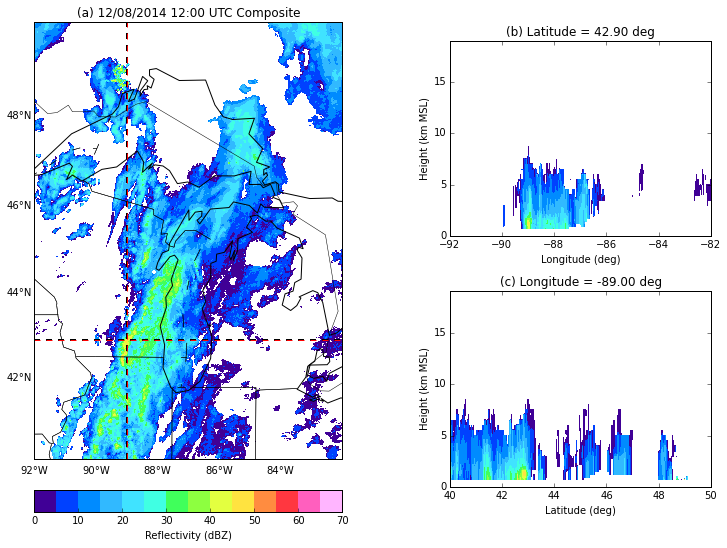

In [6]:
display.three_panel_plot(lat=42.9, lon=-89, latrange=[40,50], lonrange=[-92,-82], 
                         parallels=2, meridians=2)

You can also read gzipped grib2s, and you don't need to keep the intermediary netCDFs if you don't want to. Plus, you can read only a subset of the files for each time step, to create a coarser-resolution MosaicTile. This can also speed up the read time if you are only interested in certain vertical levels. The default is to not output a bunch of text (verbose=False).

In [7]:
path = '/Users/tjlang/Documents/Python/DataForTesting/mosaics_gribs/'
files = glob.glob(path + '*')
print(files[0])
tile = mmmpy.MosaicTile(filename=files[::2], keep_nc=False)

/Users/tjlang/Documents/Python/DataForTesting/mosaics_gribs/MergedRefl_20150217_235829_00.50.grib2.gz


In [8]:
print(tile.Height)

[  0.5   1.    1.5   2.    2.5   3.    4.    5.    6.    7.    8.    9.
  11.   13.   15.   17.   19. ]


See? Way fewer than 33 levels now.

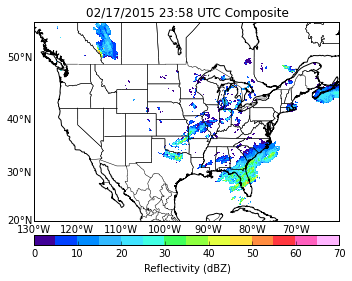

In [9]:
display = mmmpy.MosaicDisplay(tile)
display.plot_horiz()

Now, if you want you can also read the intermediary netCDFs if they've already been created and kept. This skips the wgrib2 stuff. You can also just pass MosaicTile a single file, so you just get a single vertical level.

In [10]:
ncfiles = glob.glob(TMPDIR + '*.nc')
print(ncfiles[0])
test = mmmpy.MosaicTile(ncfiles[0])

/Users/tjlang/Documents/Python/DataForTesting/tmpdir/MergedRefl_20150410_084628_00.50.grib2.nc



********************
plot_horiz():
Executing plot
Attempting to plot cross-section thru 5 km MSL
Actually taking cross-section thru 0.5 km MSL
********************



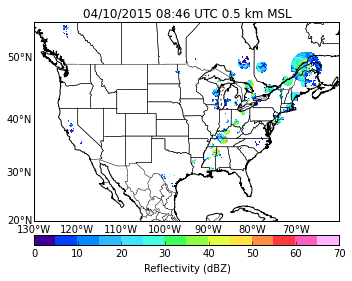

In [11]:
dis = mmmpy.MosaicDisplay(test)
dis.plot_horiz(level=5, verbose=True)

Note how only the 0.5-km file was read. So that is all it can plot.

One final trick - MosaicTile now accepts latrange and lonrange keywords when reading grib2 files. This will use wgrib2 (via the -small_grib option) to subsection the data before creating the netCDFs and reading them in. You can really speed up the ingest process this way.

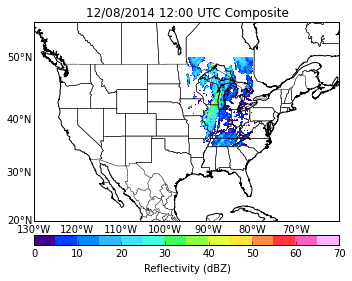

In [12]:
tile = mmmpy.MosaicTile(filename=gf, latrange=[35,50], lonrange=[-95,-80])
display = mmmpy.MosaicDisplay(tile)
display.plot_horiz()

###Binary Output

MMM-Py can subsection existing data and output to a binary file, the same format as the original MRMS binaries. These are of course readable by MMM-Py. It can also output 2-D composites as binary MRMS files.

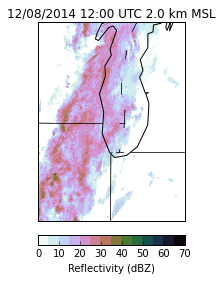

In [13]:
# Subsection and write to file
tile.subsection(latrange=[40, 45], lonrange=[-90, -85], zrange=[0, 5])
tile.write_mosaic_binary('output.dat.gz')
tile_new = mmmpy.MosaicTile('output.dat.gz')
display = mmmpy.MosaicDisplay(tile_new)
display.plot_horiz(latrange=[tile_new.Latitude.min(), tile_new.Latitude.max()],
                   lonrange=[tile_new.Longitude.min(), tile_new.Longitude.max()],
                   cmap='cubehelix_r', level=2.0)

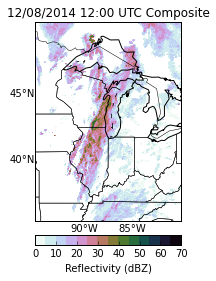

In [14]:
# Composite output
tile = mmmpy.MosaicTile(filename=gf, latrange=[35,50], lonrange=[-95,-80])
tile.output_composite('comp.dat.gz')
tile_new = mmmpy.MosaicTile('comp.dat.gz')
display = mmmpy.MosaicDisplay(tile_new)
display.plot_horiz(latrange=[tile_new.Latitude.min(), tile_new.Latitude.max()],
                   lonrange=[tile_new.Longitude.min(), tile_new.Longitude.max()],
                   cmap='cubehelix_r', parallels=5, meridians=5)